In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [88]:
#afisam data setul water_problem trebuie sa punem encoding ca sa ne afiseze cu litere latine
df = pd.read_csv('water_problem_nlp_en_for_Kaggle_100.csv', encoding='latin1')
df

,text;env_problems;pollution;treatment;climate;biomonitoring
0,In the Southern Bug basin wastewater is discha...
1,This amount is distributed as follows: urban a...
2,Despite the similar volumes of discharged wast...
3,They bring 84% of organic pollution 86% of pho...
4,The input of the industry is between 7â21% a...
...,...
95,Chemical composition of water bodies shall com...
96,According to the Directive provisions water bo...
97,Besides in the field of data processing during...
98,Use of these values was offered by the Monitor...


In [89]:
#procesarea textului, trebuie sa importam clasele
from sklearn.base import BaseEstimator, TransformerMixin

In [90]:
# modul 1, normalizare     
#self obiectul care cheama functia
class TextNormalizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
#x este un string
    def transform(self, X, y=None):
        #creem o copie
        X_copy = X.copy()
        for i in range(len(X_copy)):
            X_copy[i] = X_copy[i].lower()              
# scoatem new linerulie
            X_copy[i] = X_copy[i].replace('\n', ' ')
            X_copy[i] = X_copy[i].replace('\r', ' ')
# functia strip scoate din stinga si dreapta spatiile
            X_copy[i] = X_copy[i].strip()    
        return X_copy

In [91]:
X = df['text;env_problems;pollution;treatment;climate;biomonitoring'].values
y = df['text;env_problems;pollution;treatment;climate;biomonitoring'].values

In [92]:
X

array(['In the Southern Bug basin wastewater is discharged from 341 organized sources (Map 5). In 2011 (reference year) 211 mln. m3 was discharged in total.;1;1;;;',
       'This amount is distributed as follows: urban and rural housing wastewater treatment facilities (WWTPs - vodocanals) â\x80\x93 70 mln. m3 (57 users) industry â\x80\x93 50 mln. m3 (79 users) agriculture â\x80\x93 90 mln. m3 (193 users) other users â\x80\x93 1 mln. m3 (12 users) (Picture. 2.1). ;1;1;;;',
       'Despite the similar volumes of discharged wastewater major part of pollutants comes with communal WWTPs.;1;1;;;',
       'They bring 84% of organic pollution 86% of phosphate ions and 84% of mineral nitrogen 91% of ammonia nitrogen 87% nitrate nitrogen and 79% nitrite nitrogen.;1;1;;;',
       'The input of the industry is between 7â\x80\x9321% and agriculture has the lowest impact on water bodies - 0â\x80\x936%. Of the 92 urban areas only 51 localities (55%) have centralized collection of communal waste water

In [93]:
#trebuie sa cautam hapacsele
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [94]:
class WordExctractor(BaseEstimator, TransformerMixin): #gaseste hapaxele si  
    def __init__(self, language, tokenize):
        self.language = language
        self.stopwords = stopwords.words(self.language)
        self.tokenize = tokenize
        
    def fit(self, X, y=None):
        general_freq = FreqDist()
        for txt in X:
            freq_dist = FreqDist(self.tokenize(txt)) #freq_dist calculeaza distributia pe toate textele
            general_freq.update(freq_dist)
        self.hapaxes = general_freq.hapaxes()
        return self
        
    def transform(self, X, y=None):
        X_copy = X.copy()
        for i in range(len(X_copy)):
            X_copy[i] = ' '.join([token for token in self.tokenize(X_copy[i])
                if token not in self.stopwords and token not in self.hapaxes])
        return X_copy

In [95]:
#Pas 3. aplicam steemer
class ApplyStemmer(BaseEstimator, TransformerMixin):
    def __init__(self, stemmer, tokenize):
        self.stemmer = stemmer
        self.tokenize = tokenize
        
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        for i in range(len(X_copy)):
            X_copy[i] = ' '.join([self.stemmer.stem(token)
                    for token in self.tokenize(X_copy[i])])
        return X_copy

In [96]:
# vedem rezultatul cu Pipeline si LogisticRegression

In [97]:
#unim toate componenetele impreuna cu sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [98]:
pipe = Pipeline([
    ('Normalization', TextNormalizer()),
    ('Word Extraction', WordExctractor('english', word_tokenize)),
    ('Apply Stemmer', ApplyStemmer(PorterStemmer(), word_tokenize)),
    ('Vectorizarion', CountVectorizer()),
    ('Model', LogisticRegression())
])

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [100]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('Normalization', TextNormalizer()),
                ('Word Extraction',
                 WordExctractor(language='english',
                                tokenize=<function word_tokenize at 0x000001B35A9B5F78>)),
                ('Apply Stemmer',
                 ApplyStemmer(stemmer=<PorterStemmer>,
                              tokenize=<function word_tokenize at 0x000001B35A9B5F78>)),
                ('Vectorizarion', CountVectorizer()),
                ('Model', LogisticRegression())])

In [101]:
y_pred = pipe.predict(X_test)

In [102]:
y_pred

array(['Average annual air temperature varies from 7.1oC to 10.0oC.;0;;;1;',
       'The major discharges are done by three main cities (Vinnitsa Khmelnitsky and Kirovograd). Here we can observe the direct dependency of discharges from the number of population.;1;1;;;',
       'There are 6594 rivers flowing in Southern Bug basin;0;;;;',
       'There are 6594 rivers flowing in Southern Bug basin;0;;;;',
       'In the lower part of the basin snow cover is set in the second half of December and melts in the end of February â\x80\x93 beginning of March.;0;;;1;',
       'There are 6594 rivers flowing in Southern Bug basin;0;;;;',
       'To conclude the issue of the pollution of the Southern Bug by inorganic nitrogen compounds we made a research of the change in its contains along the length of the river.;0;;;;',
       'For this part of the basin winter season is characterized by precipitations in the form of snow and frequent fogs.;0;;;1;',
       'In May thunderstorms begin.;0;;;1;',
 

In [103]:
accuracy_score(y_pred, y_test)

0.0

c:\users\mecc\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\mecc\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 147 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\mecc\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\users\mecc\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 147 missing from current font.
  font.set_text(s, 0, flags=flags)


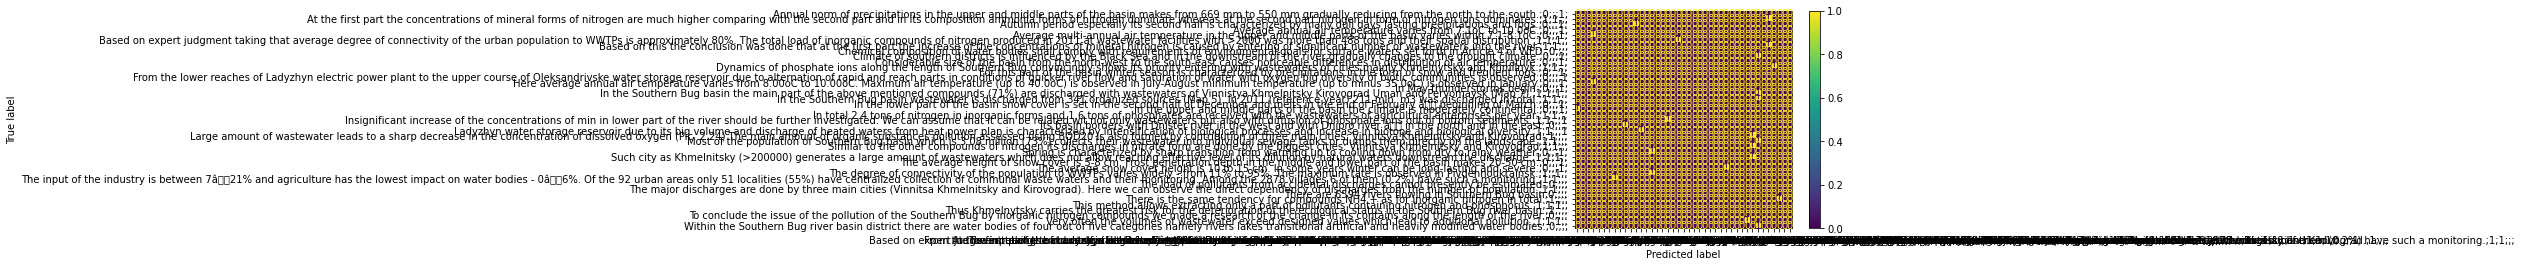

In [104]:
plot_confusion_matrix(pipe, X_test, y_test)

In [105]:
#aflam rezulatul cu KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

In [106]:
kne = Pipeline([
    ('Normalization', TextNormalizer()),
    ('Word Extraction', WordExctractor('english', word_tokenize)),
    ('Apply Stemmer', ApplyStemmer(PorterStemmer(), word_tokenize)),
    ('Vectorizarion', CountVectorizer()),
    ('Model', KNeighborsClassifier())
])

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [108]:
kne.fit(X_train, y_train)

Pipeline(steps=[('Normalization', TextNormalizer()),
                ('Word Extraction',
                 WordExctractor(language='english',
                                tokenize=<function word_tokenize at 0x000001B35A9B5F78>)),
                ('Apply Stemmer',
                 ApplyStemmer(stemmer=<PorterStemmer>,
                              tokenize=<function word_tokenize at 0x000001B35A9B5F78>)),
                ('Vectorizarion', CountVectorizer()),
                ('Model', KNeighborsClassifier())])

In [109]:
y_pred = kne.predict(X_test)

In [110]:
y_pred

array(['Air circulation with which air displacement from Atlantic Arctic and Mediterranean is connected plays an important role in climate formation in the Southern Bug basin.;0;;;1;',
       'In May thunderstorms begin.;0;;;1;',
       'Here vegetation covers 12% of the whole area. 9% of them comprises forests about 2% - meadows and about 1% - bogs.;0;;;;1',
       'In May thunderstorms begin.;0;;;1;',
       'In May thunderstorms begin.;0;;;1;',
       'It is worth of mentioning the low level of treatment of phosphor compounds in wastewater of Smoline Katerynopil Sazonivka Vatutino Kyrovograd and Khmelnitsky.;1;1;1;;',
       'Here vegetation covers 12% of the whole area. 9% of them comprises forests about 2% - meadows and about 1% - bogs.;0;;;;1',
       'Absolute elevations vary from 120-150 m in the north to 10-20 m in the south.;0;;;;',
       'Absolute elevations vary from 120-150 m in the north to 10-20 m in the south.;0;;;;',
       'In May thunderstorms begin.;0;;;1;',
      

In [111]:
accuracy_score(y_pred, y_test)

0.0

In [112]:
# train accuracy
accuracy_score(y_train, y_train)

1.0

c:\users\mecc\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\mecc\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 147 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\mecc\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\users\mecc\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 147 missing from current font.
  font.set_text(s, 0, flags=flags)


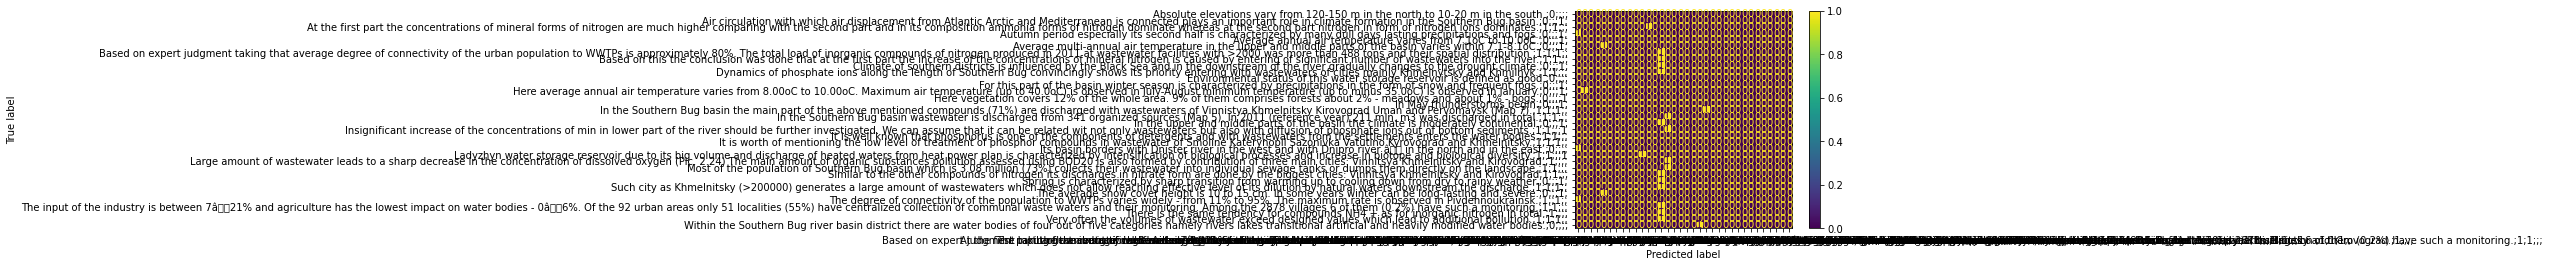

In [113]:
plot_confusion_matrix(kne, X_test, y_test)

In [114]:
#aflam rezultatele cu DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

In [115]:
decision = Pipeline([
    ('Normalization', TextNormalizer()),
    ('Word Extraction', WordExctractor('english', word_tokenize)),
    ('Apply Stemmer', ApplyStemmer(PorterStemmer(), word_tokenize)),
    ('Vectorizarion', CountVectorizer()),
    ('Model', DecisionTreeClassifier())
])

In [116]:
decision.fit(X_train, y_train)

Pipeline(steps=[('Normalization', TextNormalizer()),
                ('Word Extraction',
                 WordExctractor(language='english',
                                tokenize=<function word_tokenize at 0x000001B35A9B5F78>)),
                ('Apply Stemmer',
                 ApplyStemmer(stemmer=<PorterStemmer>,
                              tokenize=<function word_tokenize at 0x000001B35A9B5F78>)),
                ('Vectorizarion', CountVectorizer()),
                ('Model', DecisionTreeClassifier())])

In [117]:
y_pred = decision.predict(X_test)

In [118]:
y_pred

array(['Average annual air temperature varies from 7.1oC to 10.0oC.;0;;;1;',
       'In large cities with EH close or greater than 100000 EH connection to sewers ranges 85-92 80% in towns usually no more than 30% in rural settlements. Due to lack of data no accurate estimates can be given.;1;;1;;',
       'The current state of sewage networks is a source of concern since about 24% of them due to financial difficulties were not repaired.;1;;1;;',
       'Air circulation with which air displacement from Atlantic Arctic and Mediterranean is connected plays an important role in climate formation in the Southern Bug basin.;0;;;1;',
       'Most of wastewater treatment facilities require urgent modernization and reconstruction.;1;1;1;;',
       'Air circulation with which air displacement from Atlantic Arctic and Mediterranean is connected plays an important role in climate formation in the Southern Bug basin.;0;;;1;',
       'The obtained results show that the main part (77%) of inorganic n

In [119]:
accuracy_score(y_pred, y_test)

0.0

In [120]:
# train accuracy
accuracy_score(y_train, y_train)

1.0

c:\users\mecc\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\mecc\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 147 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\mecc\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 156 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\mecc\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 157 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\mecc\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flag

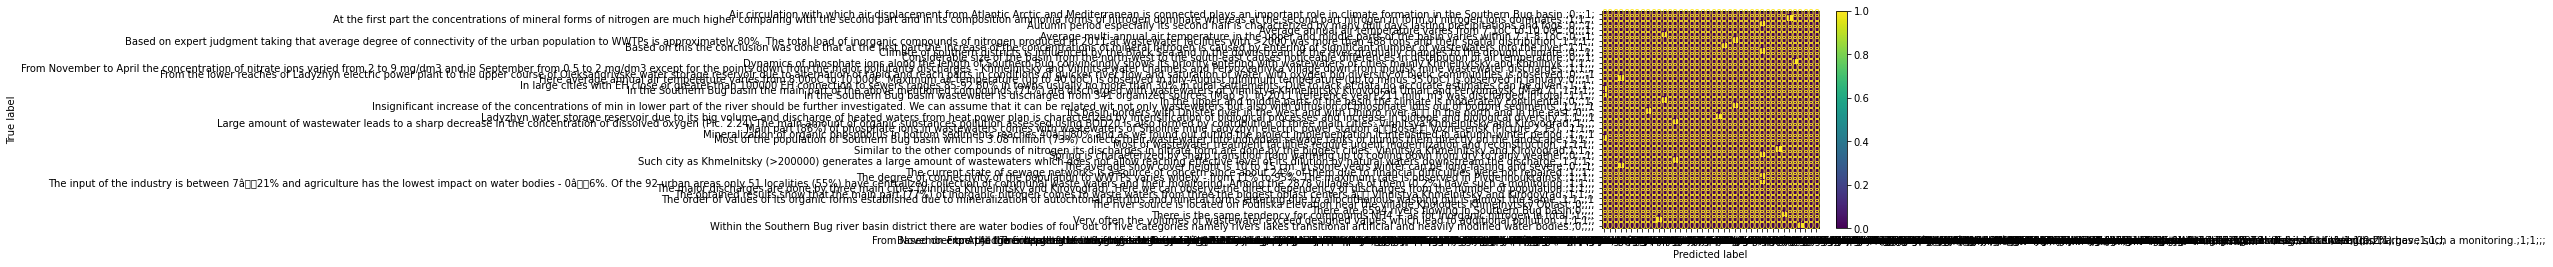

In [121]:
plot_confusion_matrix(decision, X_test, y_test)

In [127]:
# aflam rezultatele cu RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

In [128]:
random = Pipeline([
    ('Normalization', TextNormalizer()),
    ('Word Extraction', WordExctractor('english', word_tokenize)),
    ('Apply Stemmer', ApplyStemmer(PorterStemmer(), word_tokenize)),
    ('Vectorizarion', CountVectorizer()),
    ('Model', RandomForestClassifier())
])

In [129]:
random.fit(X_train, y_train)

Pipeline(steps=[('Normalization', TextNormalizer()),
                ('Word Extraction',
                 WordExctractor(language='english',
                                tokenize=<function word_tokenize at 0x000001B35A9B5F78>)),
                ('Apply Stemmer',
                 ApplyStemmer(stemmer=<PorterStemmer>,
                              tokenize=<function word_tokenize at 0x000001B35A9B5F78>)),
                ('Vectorizarion', CountVectorizer()),
                ('Model', RandomForestClassifier())])

In [130]:
y_pred = random.predict(X_test)

In [131]:
y_pred

array(['Average annual air temperature varies from 7.1oC to 10.0oC.;0;;;1;',
       'The load of pollutants from accidental discharges cannot presently be estimated.;0;;;;',
       'There are 6594 rivers flowing in Southern Bug basin;0;;;;',
       'There are 6594 rivers flowing in Southern Bug basin;0;;;;',
       'In the lower part of the basin snow cover is set in the second half of December and melts in the end of February â\x80\x93 beginning of March.;0;;;1;',
       'There are 6594 rivers flowing in Southern Bug basin;0;;;;',
       'In total 2.4 tons of nitrogen in inorganic forms and 1.6 tons of phosphates are received with the wastewaters of agricultural enterprises per year.;1;1;;;',
       'In May thunderstorms begin.;0;;;1;',
       'In May thunderstorms begin.;0;;;1;',
       'There are 6594 rivers flowing in Southern Bug basin;0;;;;',
       'The load of pollutants from accidental discharges cannot presently be estimated.;0;;;;',
       'This method allows extracting only

In [132]:
accuracy_score(y_pred, y_test)

0.0

In [133]:
# train accuracy
accuracy_score(y_train, y_train)

1.0

c:\users\mecc\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\mecc\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 147 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\mecc\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\users\mecc\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 147 missing from current font.
  font.set_text(s, 0, flags=flags)


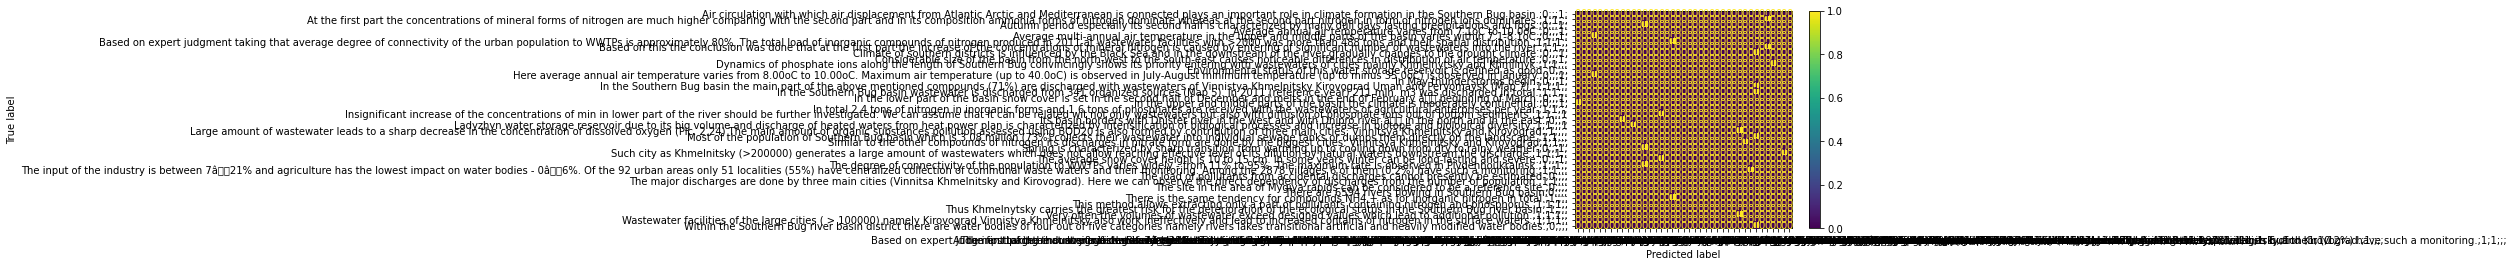

In [134]:
plot_confusion_matrix(random, X_test, y_test)